<a href="https://colab.research.google.com/github/amitav710/SAiDL-Spring-Assignment-2022/blob/main/SRResNet_transposed_conv_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Conv2D, ReLU, BatchNormalization, Add
from keras import layers
from tensorflow.keras.optimizers import Adam
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.utils import plot_model

In [ ]:
ds_train, info_train = tfds.load('oxford_iiit_pet', split='train', with_info=True, shuffle_files=False, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteP39LYN/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteP39LYN/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


,image,label
0,"[[[3, 3, 3], [5, 3, 4], [7, 5, 6], [4, 2, 3], ...",33
1,"[[[5, 9, 8], [3, 4, 0], [11, 24, 4], [36, 51, ...",12
2,"[[[44, 32, 6], [44, 34, 7], [44, 34, 7], [41, ...",9
3,"[[[108, 130, 117], [114, 133, 127], [108, 128,...",32
4,"[[[237, 228, 91], [236, 228, 93], [230, 225, 8...",33


In [ ]:
x_train=[]
for data in ds_train:
  x,_ = data
  x=x.numpy()
  x=cv2.resize(x, (300,300))
  x_train.append(x)
x_train = np.array(x_train)
x_train.shape

(3680, 300, 300, 3)

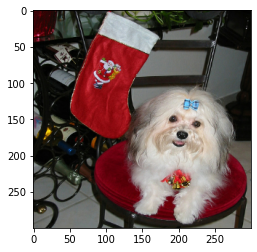

In [ ]:
plt.imshow(x_train[77])

# Converting into Low-Res Image by Downscaling and Blurring

In [ ]:
!pip install tensorflow_addons==0.15

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
def lowres(img:np.ndarray): #dealing with 0 to 1 float values after conversion
  img=tfa.image.gaussian_filter2d(img, filter_shape=(3,3))
  new=tf.image.resize(img, (100,100), method=tf.image.ResizeMethod.AREA, preserve_aspect_ratio=False, antialias=False)
  return new/255

In [ ]:
inputs=[]
for i in x_train:
  a=lowres(i)
  inputs.append(a)
inputs=np.array(inputs)

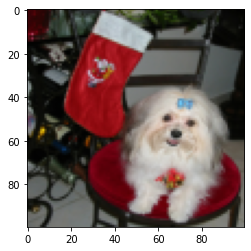

In [ ]:
plt.imshow(inputs[77])

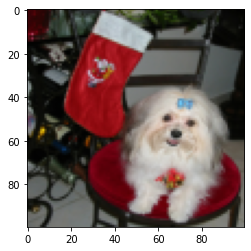

In [ ]:
plt.imshow(lowres(x_train[77]))

# Loading our Weights

In [ ]:
!pwd

/content


In [ ]:
pb_model = "./transposed_wts"
# Loading the Tensorflow Saved Model (PB)
SRResNet = tf.keras.models.load_model(pb_model)
print(SRResNet.summary())

# Building our ResNet model

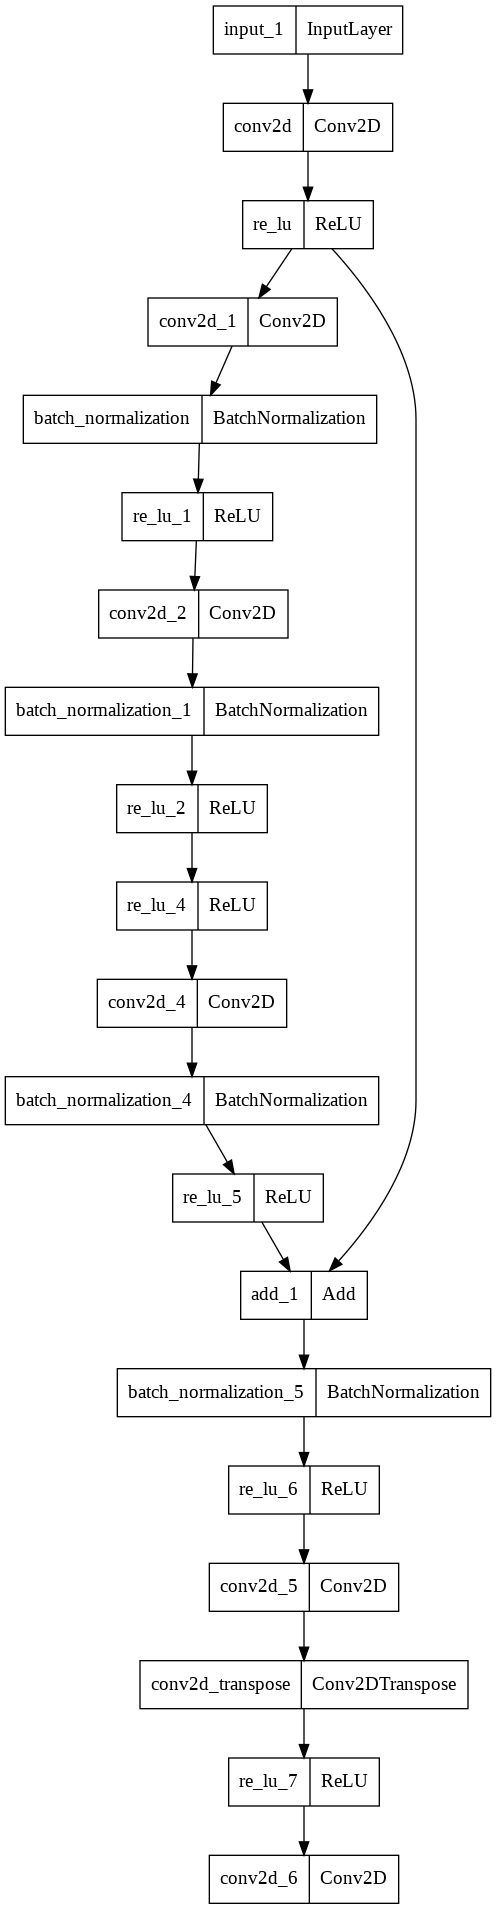

In [ ]:
shape=(100,100,3)
input=layers.Input(shape)

x = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same', use_bias=True, input_shape=(100, 100, 3)))(input)
x = (ReLU())(x)
xcopy1=x
xcopy2=x
xcopy3=x
x1 = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same'))(xcopy1)
x1 = BatchNormalization(momentum=0.02)(x1)
x1 = (ReLU())(x1)
x1 = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same'))(x1)
x1 = BatchNormalization(momentum=0.02)(x1)
x1 = (ReLU())(x1)

x2 = (ReLU())(x1)
x2 = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same'))(x2)
x2 = BatchNormalization(momentum=0.02)(x2)
x2 = (ReLU())(x2)

x=Add()([xcopy3,x2])
x = (BatchNormalization(momentum=0.02))(x)
x = (ReLU())(x)

x=(Conv2D(filters=27, kernel_size = (3, 3), kernel_initializer='glorot_uniform', activation="relu", padding= "same"))(x)
x=tf.keras.layers.Conv2DTranspose(filters=9, kernel_size = (3, 3), strides=3, kernel_initializer='glorot_uniform', activation="relu")(x)
x = (ReLU())(x)

x= (Conv2D(filters=3, kernel_size = (3, 3), kernel_initializer='glorot_uniform', activation='linear', padding='same', use_bias=True))(x)

SRResNet = tf.keras.Model(inputs=input, outputs=x)
plot_model(SRResNet)

In [ ]:
adam = Adam(learning_rate=0.0003)

In [ ]:
SRResNet.compile(optimizer= adam, loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=10, mode='min', restore_best_weights=True)

In [ ]:
model_save_location='transposed_wts'

In [ ]:
checkpoint=keras.callbacks.ModelCheckpoint(model_save_location, monitor='mean_squared_error', save_best_only=True, mode='min')

In [ ]:
SRResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  4864        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 100, 100, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history=SRResNet.fit(x=inputs, y=x_train, epochs=75, batch_size=32, callbacks=[early_stop, checkpoint])

Epoch 1/75
115/115 [==============================] - ETA: 0s - loss: 15057.1016 - mean_squared_error: 15057.1045INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 87s 621ms/step - loss: 15057.1016 - mean_squared_error: 15057.1045
Epoch 2/75
115/115 [==============================] - ETA: 0s - loss: 3071.8977 - mean_squared_error: 3071.8967INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 616ms/step - loss: 3071.8977 - mean_squared_error: 3071.8967
Epoch 3/75
115/115 [==============================] - ETA: 0s - loss: 864.9311 - mean_squared_error: 864.9310INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 864.9311 - mean_squared_error: 864.9310
Epoch 4/75
115/115 [==============================] - ETA: 0s - loss: 755.1663 - mean_squared_error: 755.1666INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 755.1663 - mean_squared_error: 755.1666
Epoch 5/75
115/115 [==============================] - ETA: 0s - loss: 708.3144 - mean_squared_error: 708.3146INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 616ms/step - loss: 708.3144 - mean_squared_error: 708.3146
Epoch 6/75
115/115 [==============================] - ETA: 0s - loss: 679.9998 - mean_squared_error: 679.9995INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 616ms/step - loss: 679.9998 - mean_squared_error: 679.9995
Epoch 7/75
115/115 [==============================] - ETA: 0s - loss: 666.9816 - mean_squared_error: 666.9816INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 666.9816 - mean_squared_error: 666.9816
Epoch 8/75
115/115 [==============================] - ETA: 0s - loss: 627.0146 - mean_squared_error: 627.0148INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 616ms/step - loss: 627.0146 - mean_squared_error: 627.0148
Epoch 9/75
115/115 [==============================] - ETA: 0s - loss: 593.4940 - mean_squared_error: 593.4941INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 593.4940 - mean_squared_error: 593.4941
Epoch 10/75
115/115 [==============================] - ETA: 0s - loss: 520.1794 - mean_squared_error: 520.1792INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 520.1794 - mean_squared_error: 520.1792
Epoch 11/75
115/115 [==============================] - ETA: 0s - loss: 443.0015 - mean_squared_error: 443.0015INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 443.0015 - mean_squared_error: 443.0015
Epoch 12/75
115/115 [==============================] - ETA: 0s - loss: 411.2406 - mean_squared_error: 411.2406INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 616ms/step - loss: 411.2406 - mean_squared_error: 411.2406
Epoch 13/75
115/115 [==============================] - ETA: 0s - loss: 381.5518 - mean_squared_error: 381.5518INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 381.5518 - mean_squared_error: 381.5518
Epoch 14/75
115/115 [==============================] - 68s 592ms/step - loss: 385.6631 - mean_squared_error: 385.6631
Epoch 15/75
115/115 [==============================] - ETA: 0s - loss: 359.1901 - mean_squared_error: 359.1901INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 359.1901 - mean_squared_error: 359.1901
Epoch 16/75
115/115 [==============================] - ETA: 0s - loss: 345.3728 - mean_squared_error: 345.3727INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 345.3728 - mean_squared_error: 345.3727
Epoch 17/75
115/115 [==============================] - 68s 593ms/step - loss: 350.8100 - mean_squared_error: 350.8101
Epoch 18/75
115/115 [==============================] - ETA: 0s - loss: 331.1882 - mean_squared_error: 331.1882INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 331.1882 - mean_squared_error: 331.1882
Epoch 19/75
115/115 [==============================] - 68s 593ms/step - loss: 334.0216 - mean_squared_error: 334.0217
Epoch 20/75
115/115 [==============================] - ETA: 0s - loss: 307.7155 - mean_squared_error: 307.7155INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 307.7155 - mean_squared_error: 307.7155
Epoch 21/75
115/115 [==============================] - ETA: 0s - loss: 304.6565 - mean_squared_error: 304.6564INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 304.6565 - mean_squared_error: 304.6564
Epoch 22/75
115/115 [==============================] - ETA: 0s - loss: 303.0346 - mean_squared_error: 303.0346INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 303.0346 - mean_squared_error: 303.0346
Epoch 23/75
115/115 [==============================] - ETA: 0s - loss: 294.5447 - mean_squared_error: 294.5448INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 616ms/step - loss: 294.5447 - mean_squared_error: 294.5448
Epoch 24/75
115/115 [==============================] - ETA: 0s - loss: 291.0922 - mean_squared_error: 291.0921INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 291.0922 - mean_squared_error: 291.0921
Epoch 25/75
115/115 [==============================] - 68s 592ms/step - loss: 296.2780 - mean_squared_error: 296.2781
Epoch 26/75
115/115 [==============================] - 68s 592ms/step - loss: 294.3722 - mean_squared_error: 294.3722
Epoch 27/75
115/115 [==============================] - 68s 592ms/step - loss: 306.5190 - mean_squared_error: 306.5190
Epoch 28/75
115/115 [==============================] - 68s 592ms/step - loss: 296.7238 - mean_squared_error: 296.7238
Epoch 29/75
115/115 [==============================] - ETA: 0s - loss: 276.7535 - mean_squared_error: 276.7534INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 276.7535 - mean_squared_error: 276.7534
Epoch 30/75
115/115 [==============================] - 68s 592ms/step - loss: 279.9365 - mean_squared_error: 279.9366
Epoch 31/75
115/115 [==============================] - ETA: 0s - loss: 271.5755 - mean_squared_error: 271.5755INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 271.5755 - mean_squared_error: 271.5755
Epoch 32/75
115/115 [==============================] - 68s 592ms/step - loss: 277.3129 - mean_squared_error: 277.3129
Epoch 33/75
115/115 [==============================] - 68s 592ms/step - loss: 276.8717 - mean_squared_error: 276.8717
Epoch 34/75
115/115 [==============================] - 68s 592ms/step - loss: 278.0456 - mean_squared_error: 278.0457
Epoch 35/75
115/115 [==============================] - ETA: 0s - loss: 263.0381 - mean_squared_error: 263.0381INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 614ms/step - loss: 263.0381 - mean_squared_error: 263.0381
Epoch 36/75
115/115 [==============================] - 68s 592ms/step - loss: 274.3006 - mean_squared_error: 274.3005
Epoch 37/75
115/115 [==============================] - 68s 591ms/step - loss: 276.4269 - mean_squared_error: 276.4269
Epoch 38/75
115/115 [==============================] - 68s 591ms/step - loss: 269.4442 - mean_squared_error: 269.4442
Epoch 39/75
115/115 [==============================] - 68s 592ms/step - loss: 276.1581 - mean_squared_error: 276.1582
Epoch 40/75
115/115 [==============================] - ETA: 0s - loss: 260.7544 - mean_squared_error: 260.7543INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 260.7544 - mean_squared_error: 260.7543
Epoch 41/75
115/115 [==============================] - ETA: 0s - loss: 259.9470 - mean_squared_error: 259.9470INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 614ms/step - loss: 259.9470 - mean_squared_error: 259.9470
Epoch 42/75
115/115 [==============================] - 68s 592ms/step - loss: 263.5812 - mean_squared_error: 263.5811
Epoch 43/75
115/115 [==============================] - 68s 592ms/step - loss: 263.5524 - mean_squared_error: 263.5524
Epoch 44/75
115/115 [==============================] - 68s 592ms/step - loss: 260.7705 - mean_squared_error: 260.7705
Epoch 45/75
115/115 [==============================] - ETA: 0s - loss: 258.6695 - mean_squared_error: 258.6696INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 616ms/step - loss: 258.6695 - mean_squared_error: 258.6696
Epoch 46/75
115/115 [==============================] - ETA: 0s - loss: 257.4460 - mean_squared_error: 257.4460INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 614ms/step - loss: 257.4460 - mean_squared_error: 257.4460
Epoch 47/75
115/115 [==============================] - 68s 592ms/step - loss: 266.9476 - mean_squared_error: 266.9477
Epoch 48/75
115/115 [==============================] - ETA: 0s - loss: 251.8991 - mean_squared_error: 251.8990INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 251.8991 - mean_squared_error: 251.8990
Epoch 49/75
115/115 [==============================] - 68s 592ms/step - loss: 252.4835 - mean_squared_error: 252.4835
Epoch 50/75
115/115 [==============================] - ETA: 0s - loss: 248.1944 - mean_squared_error: 248.1944INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 248.1944 - mean_squared_error: 248.1944
Epoch 51/75
115/115 [==============================] - ETA: 0s - loss: 243.1881 - mean_squared_error: 243.1882INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 243.1881 - mean_squared_error: 243.1882
Epoch 52/75
115/115 [==============================] - 68s 592ms/step - loss: 259.2676 - mean_squared_error: 259.2676
Epoch 53/75
115/115 [==============================] - 68s 592ms/step - loss: 249.0805 - mean_squared_error: 249.0805
Epoch 54/75
115/115 [==============================] - 68s 592ms/step - loss: 247.4510 - mean_squared_error: 247.4510
Epoch 55/75
115/115 [==============================] - 68s 592ms/step - loss: 244.8555 - mean_squared_error: 244.8554
Epoch 56/75
115/115 [==============================] - 68s 592ms/step - loss: 251.5798 - mean_squared_error: 251.5798
Epoch 57/75
115/115 [==============================] - 69s 598ms/step - loss: 248.0861 - mean_squared_error: 248.0861
Epoch 58/75
115/115 [==============================] - 68s 592ms/step - loss: 243.5796 - mean_squared_error: 243.5795
Epoch 59/75
115/115 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 614ms/step - loss: 238.9155 - mean_squared_error: 238.9155
Epoch 60/75
115/115 [==============================] - ETA: 0s - loss: 237.5117 - mean_squared_error: 237.5116INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 237.5117 - mean_squared_error: 237.5116
Epoch 61/75
115/115 [==============================] - ETA: 0s - loss: 233.3244 - mean_squared_error: 233.3244INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 616ms/step - loss: 233.3244 - mean_squared_error: 233.3244
Epoch 62/75
115/115 [==============================] - ETA: 0s - loss: 232.8022 - mean_squared_error: 232.8022INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 232.8022 - mean_squared_error: 232.8022
Epoch 63/75
115/115 [==============================] - ETA: 0s - loss: 220.6295 - mean_squared_error: 220.6294INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 220.6295 - mean_squared_error: 220.6294
Epoch 64/75
115/115 [==============================] - 68s 592ms/step - loss: 225.7751 - mean_squared_error: 225.7751
Epoch 65/75
115/115 [==============================] - ETA: 0s - loss: 219.5086 - mean_squared_error: 219.5086INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 219.5086 - mean_squared_error: 219.5086
Epoch 66/75
115/115 [==============================] - ETA: 0s - loss: 215.7401 - mean_squared_error: 215.7401INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 215.7401 - mean_squared_error: 215.7401
Epoch 67/75
115/115 [==============================] - 68s 592ms/step - loss: 218.3735 - mean_squared_error: 218.3735
Epoch 68/75
115/115 [==============================] - ETA: 0s - loss: 206.6342 - mean_squared_error: 206.6341INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 206.6342 - mean_squared_error: 206.6341
Epoch 69/75
115/115 [==============================] - 68s 592ms/step - loss: 211.4894 - mean_squared_error: 211.4894
Epoch 70/75
115/115 [==============================] - 68s 592ms/step - loss: 207.3213 - mean_squared_error: 207.3212
Epoch 71/75
115/115 [==============================] - ETA: 0s - loss: 198.8051 - mean_squared_error: 198.8051INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 198.8051 - mean_squared_error: 198.8051
Epoch 72/75
115/115 [==============================] - ETA: 0s - loss: 195.7904 - mean_squared_error: 195.7904INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 617ms/step - loss: 195.7904 - mean_squared_error: 195.7904
Epoch 73/75
115/115 [==============================] - ETA: 0s - loss: 194.9834 - mean_squared_error: 194.9834INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 194.9834 - mean_squared_error: 194.9834
Epoch 74/75
115/115 [==============================] - ETA: 0s - loss: 191.0698 - mean_squared_error: 191.0698INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 618ms/step - loss: 191.0698 - mean_squared_error: 191.0698
Epoch 75/75
115/115 [==============================] - ETA: 0s - loss: 189.8078 - mean_squared_error: 189.8079INFO:tensorflow:Assets written to: transposed_wts/assets


INFO:tensorflow:Assets written to: transposed_wts/assets


115/115 [==============================] - 71s 615ms/step - loss: 189.8078 - mean_squared_error: 189.8079


In [ ]:
  ds_test, info_test = tfds.load('oxford_iiit_pet', split='test', with_info=True, shuffle_files=False, as_supervised=True)
  df_test = tfds.as_dataframe(ds_test.take(5), info_test)
  df_test.head()

,image,label
0,"[[[250, 241, 232], [255, 247, 238], [251, 244,...",19
1,"[[[4, 6, 3], [4, 6, 3], [4, 6, 3], [3, 5, 2], ...",20
2,"[[[100, 120, 33], [103, 123, 38], [96, 115, 34...",28
3,"[[[182, 145, 126], [179, 143, 117], [177, 145,...",28
4,"[[[184, 188, 199], [178, 185, 195], [180, 186,...",4


In [ ]:
x_test=[]
for data in ds_test:
  x,_ = data
  x=x.numpy()
  x=cv2.resize(x, (300,300))
  x_test.append(x)
x_test = np.array(x_test)
x_test.shape  

(3669, 300, 300, 3)

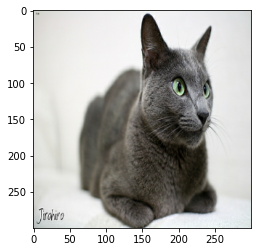

In [ ]:
plt.imshow(x_test[100])

In [ ]:
out=SRResNet.predict(np.expand_dims(lowres(x_test[100]), axis=0))

In [ ]:
out=out/255

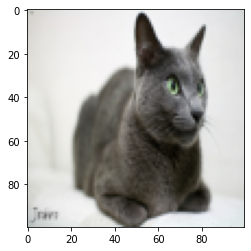

In [ ]:
plt.imshow(lowres(x_test[100]))

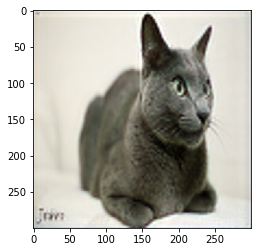

In [ ]:
plt.imshow(out[0])

In [ ]:
tf.image.psnr(out[0], x_test[100], 1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=26.066544>

In [ ]:
x100=lowres(x_test[100])

In [ ]:
x100 = tf.image.resize(x100, (300,300), method=tf.image.ResizeMethod.AREA, preserve_aspect_ratio=False, antialias=False)

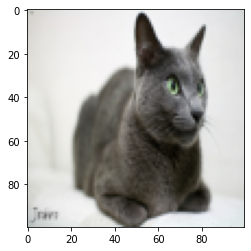

In [ ]:
plt.imshow(x100)

In [ ]:
tf.image.psnr(x100, x_test[100], 1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=26.752045>